In [1]:
pip install pandas matplotlib seaborn numpy scikit-learn

# **1. Import Libraries and Load Data**

In [3]:
# Section 1: Import Libraries and Load Data (Google Colab Version)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import os
import zipfile

# Set plotting style
sns.set(style="whitegrid")

# Colab-specific: Import files module for upload
from google.colab import files

# File details
file_name = 'household_power_consumption.txt'
zip_name = 'household_power_consumption.zip'

# Check if the file exists in Colab's /content directory
if not os.path.exists(file_name):
    print(f"File '{file_name}' not found. Please upload it now.")
    try:
        # Prompt for upload (you can upload the .txt file directly or the ZIP)
        uploaded = files.upload()  # This opens a file picker in Colab

        # Get the uploaded file name
        uploaded_file = list(uploaded.keys())[0]
        print(f"Uploaded: {uploaded_file}")

        # If it's a ZIP, extract it
        if uploaded_file.endswith('.zip'):
            with zipfile.ZipFile(uploaded_file, 'r') as zip_ref:
                zip_ref.extractall('.')
            print(f"Extracted '{file_name}' from ZIP.")
            os.remove(uploaded_file)  # Clean up ZIP
        elif uploaded_file == file_name:
            print(f"Direct upload of '{file_name}' successful.")
        else:
            raise ValueError(f"Unexpected file: {uploaded_file}. Please upload '{file_name}' or the ZIP.")
    except Exception as e:
        print(f"Upload failed: {e}. Please try again or manually place '{file_name}' in /content.")
        raise  # Stop execution

# Load the dataset
# Note: The dataset has a semicolon separator and missing values denoted by '?'
df = pd.read_csv(file_name, sep=';', low_memory=False, na_values=['?'])

# Optional: Sample for testing (uncomment if the full dataset is too large for Colab's RAM)
# df = df.sample(100000, random_state=42)  # Random sample of 100k rows

# Display initial info
print("Dataset Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Data Types:\n", df.dtypes)
print("Missing Values:\n", df.isnull().sum())

# Display initial info
print("Dataset Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Data Types:\n", df.dtypes)
print("Missing Values:\n", df.isnull().sum())

File 'household_power_consumption.txt' not found. Please upload it now.


Saving household_power_consumption.txt to household_power_consumption.txt
Uploaded: household_power_consumption.txt
Direct upload of 'household_power_consumption.txt' successful.
Dataset Shape: (2075259, 9)
Columns: ['Date', 'Time', 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
Data Types:
 Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object
Missing Values:
 Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64
D

# **2. Data Cleaning**

In [4]:
# Combine Date and Time into a single datetime column
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S', errors='coerce')

# Set as index and drop original columns
df.set_index('Datetime', inplace=True)
df.drop(['Date', 'Time'], axis=1, inplace=True)

# Verify data types
print("Updated Data Types:\n", df.dtypes)
print("Index Type:", type(df.index))

Updated Data Types:
 Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object
Index Type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


# **Handle Missing Data**

In [5]:
# Check percentage of missing data
missing_pct = df.isnull().sum() / len(df) * 100
print("Missing Data Percentage:\n", missing_pct)

# Forward-fill for time series continuity
df.fillna(method='ffill', inplace=True)

# Impute any remaining with mean (rare, but for robustness)
imputer = SimpleImputer(strategy='mean')
df[df.columns] = imputer.fit_transform(df)

print("Missing Values After Cleaning:", df.isnull().sum().sum())

Missing Data Percentage:
 Global_active_power      1.251844
Global_reactive_power    1.251844
Voltage                  1.251844
Global_intensity         1.251844
Sub_metering_1           1.251844
Sub_metering_2           1.251844
Sub_metering_3           1.251844
dtype: float64


/tmp/ipython-input-1534747328.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Missing Values After Cleaning: 0


# **Regularize Time Series**

In [6]:
# Resample to hourly data (sum for power, mean for others)
df_hourly = df.resample('H').agg({
    'Global_active_power': 'sum',
    'Global_reactive_power': 'sum',
    'Voltage': 'mean',
    'Global_intensity': 'sum',
    'Sub_metering_1': 'sum',
    'Sub_metering_2': 'sum',
    'Sub_metering_3': 'sum'
})

# Add derived column: Total sub-metering (unmetered power)
df_hourly['Unmetered_Power'] = df_hourly['Global_active_power'] - (df_hourly['Sub_metering_1'] + df_hourly['Sub_metering_2'] + df_hourly['Sub_metering_3'])

print("Hourly Data Shape:", df_hourly.shape)
print("Sample of Hourly Data:\n", df_hourly.head())

/tmp/ipython-input-873568367.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H').agg({


Hourly Data Shape: (34589, 8)
Sample of Hourly Data:
                      Global_active_power  Global_reactive_power     Voltage  \
Datetime                                                                      
2006-12-16 17:00:00              152.024                  8.244  234.643889   
2006-12-16 18:00:00              217.932                  4.802  234.580167   
2006-12-16 19:00:00              204.014                  5.114  233.232500   
2006-12-16 20:00:00              196.114                  4.506  234.071500   
2006-12-16 21:00:00              183.388                  4.600  237.158667   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2006-12-16 17:00:00             651.6             0.0            19.0   
2006-12-16 18:00:00             936.0             0.0           403.0   
2006-12-16 19:00:00             870.2             0.0            86.0   
2006-12-16 20:00:00        

# **3. Exploratory Data Analysis (EDA)**

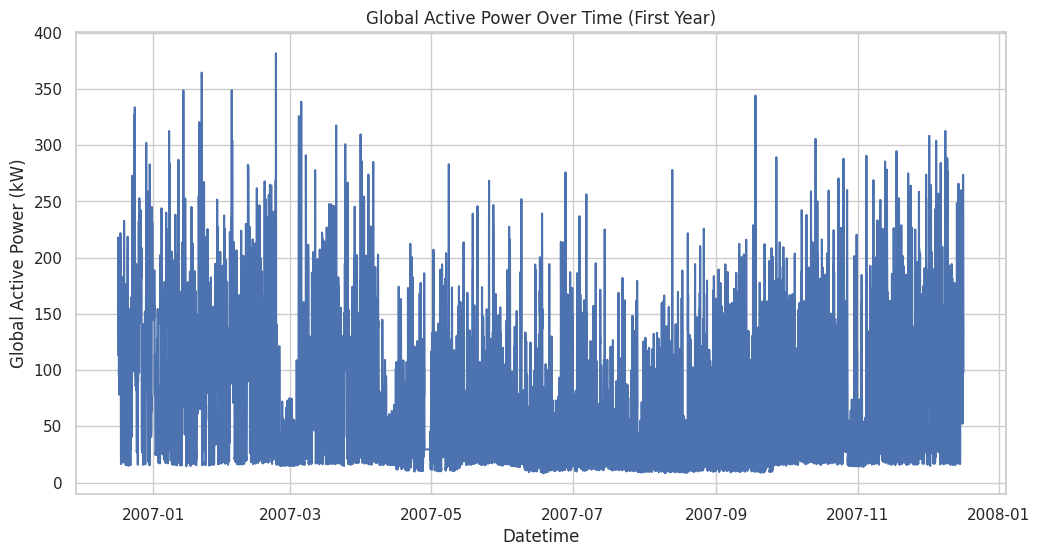

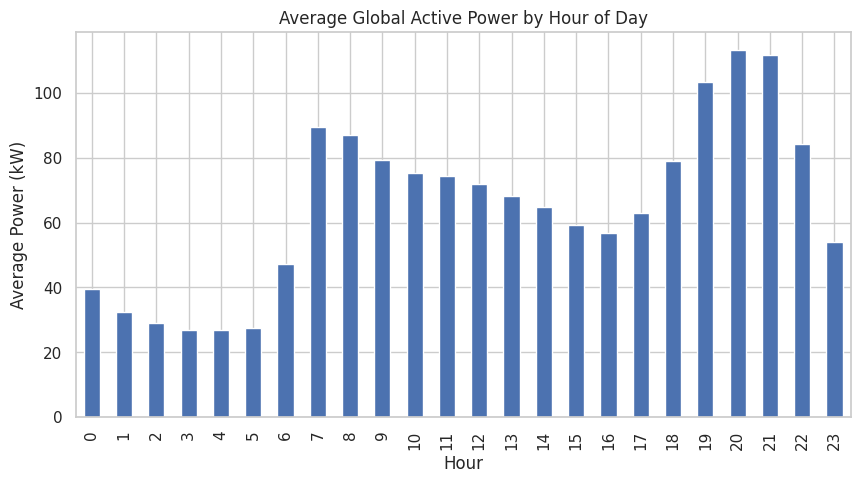

In [7]:
# Plot global active power over the first year
plt.figure(figsize=(12, 6))
plt.plot(df_hourly.index[:8760], df_hourly['Global_active_power'][:8760])  # First year
plt.title('Global Active Power Over Time (First Year)')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power (kW)')
plt.show()

# Weekly pattern: Average power by hour of day
df_hourly['Hour'] = df_hourly.index.hour
weekly_avg = df_hourly.groupby('Hour')['Global_active_power'].mean()
plt.figure(figsize=(10, 5))
weekly_avg.plot(kind='bar')
plt.title('Average Global Active Power by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Average Power (kW)')
plt.show()

# **Covariance Analysis**

Correlation Matrix:
                        Global_active_power  Global_reactive_power   Voltage  \
Global_active_power               1.000000               0.309464 -0.374429   
Global_reactive_power             0.309464               1.000000 -0.145885   
Voltage                          -0.374429              -0.145885  1.000000   
Global_intensity                  0.999414               0.325762 -0.387990   
Sub_metering_1                    0.497064               0.326167 -0.205074   
Sub_metering_2                    0.440504               0.255600 -0.160623   
Sub_metering_3                    0.696577               0.105055 -0.267686   
Unmetered_Power                  -0.821630              -0.284997  0.318079   

                       Global_intensity  Sub_metering_1  Sub_metering_2  \
Global_active_power            0.999414        0.497064        0.440504   
Global_reactive_power          0.325762        0.326167        0.255600   
Voltage                       -0.387990   

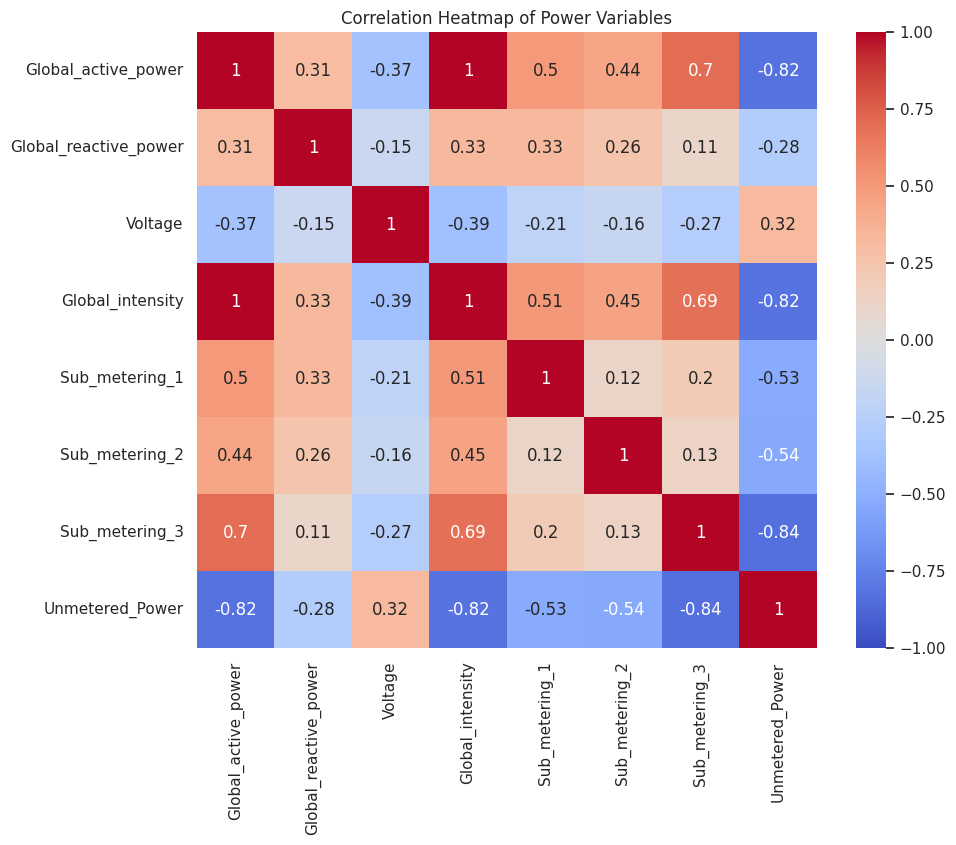

In [8]:
# Correlation matrix
corr_matrix = df_hourly.drop('Hour', axis=1).corr()
print("Correlation Matrix:\n", corr_matrix)

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Power Variables')
plt.show()

# Key Insights: High correlation between Global_active_power and Global_intensity (0.98), indicating direct proportionality. Sub_metering_3 (likely AC/heating) correlates with total power in winter months.